In [1]:
import os

import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches

from softcvi_validation import utils
from softcvi_validation.tasks.available_tasks import get_available_tasks

os.chdir(utils.get_abspath_project_root())

plt.style.use('./plots/style.mplstyle')

palette = {
        "True": "#00B945",
        "SoftCVI(a=0)": "#FF2C00",
        "SoftCVI(a=0.75)": "#0C5DA5",
        "SoftCVI(a=1)": "#FF9500",
        "SNIS-fKL": "#845B97",
        "ELBO": "#545454",
}


tasks = get_available_tasks()

method_names = list(palette.keys())

In [2]:
seed = 1
hyperparam_str = "k=8_negative=proposal"

task_samples = {
    task: {
        method_name: dict(
            jnp.load(f"results/{task}/samples/{method_name}_seed={seed}_{hyperparam_str}.npz"),
            )
        for method_name in palette.keys()
    }
    for task in get_available_tasks().keys()
}

# Rename samples and palette to use latex for alpha
for task_name, samps in task_samples.items():
    task_samples[task_name] = {
        k.replace("a=", r"$\alpha$="): v for k, v in samps.items()
    }
   
palette = {
    k.replace("a=", r"$\alpha$="): v for k, v in palette.items()
}


In [3]:
def samples_to_df(samples):
    dfs = []
    for k, samps in samples.items():
        columns = {}
        for name, arr in samps.items():
            if arr.ndim == 1:
                columns[name] = arr
            
            if arr.ndim == 2:
                for i in range(arr.shape[-1]):
                    columns[f"{name}[{i}]"] = arr[:, i]
        df = pd.DataFrame(columns)
        df["source"] = k
        dfs.append(df)

    df = pd.concat(dfs)
    return df.melt(id_vars="source", var_name="parameter", value_name="value")

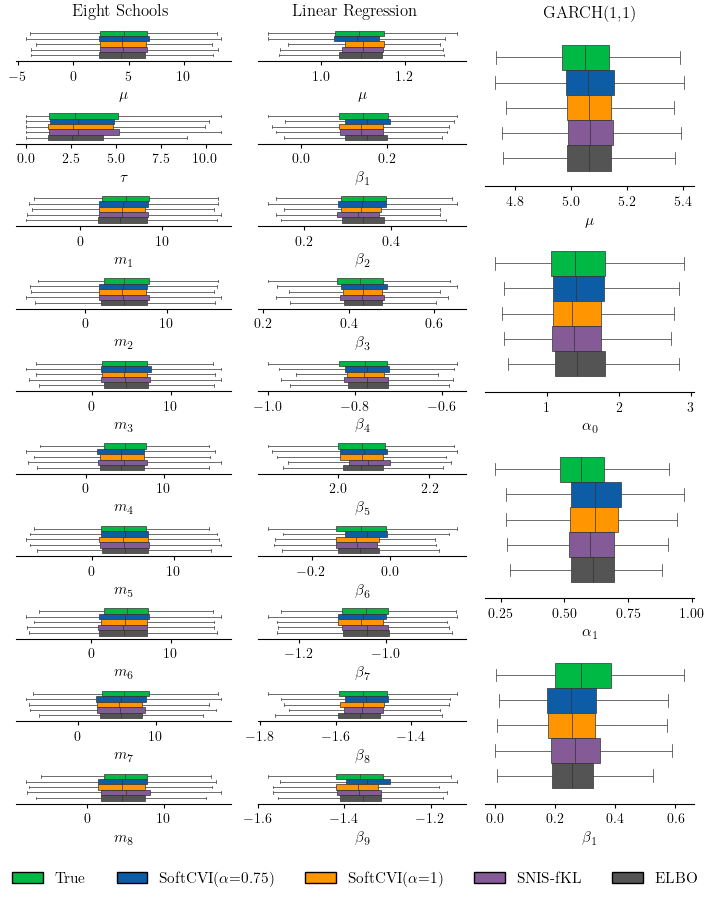

In [4]:
fig = plt.figure(layout='constrained', figsize=(7, 9))
subfigs = fig.subfigures(nrows=2, ncols=3, height_ratios=[20, 1])

param_to_plot_name = {
    "eight_schools": {"mu": r"$\mu$", "tau": r"$\tau$"} | {
        f"theta[{i}]": rf"$m_{{{i+1}}}$" for i in range(8)
        },
    "linear_regression": {
        "bias": r"$\mu$"} |
        {f"beta[{i}]": rf"$\beta_{{{i+1}}}$" for i in range(9)},
    "garch": {
        "mu": r"$\mu$",
        "alpha0": r"$\alpha_0$",
        "alpha1": r"$\alpha_1$",
        "beta1": r"$\beta_1$",
    },
}

kwargs = {
    "x": "value",
    "hue": "source",
    "showfliers": "",
    "palette": palette,
    "saturation": 1,
    "linewidth": 0.5,
}

for subfig, (task_name, param_name_dict) in zip(subfigs[0], param_to_plot_name.items(), strict=True):
    axes = subfig.subplots(nrows=len(param_name_dict))

    samples = task_samples[task_name]
    samples = {k: v for k, v in samples.items() if k!=r"SoftCVI($\alpha$=0)"}

    df = samples_to_df(samples)

    for ax, (param_name, xlabel) in zip(axes, param_name_dict.items(), strict=True):
        #plot_legend = param_name=="mu" and task_name == "eight_schools"
        
        box_plt = sns.boxplot(
            df[df["parameter"] == param_name],
            legend=False,#plot_legend,
            ax=ax,
            **kwargs,
        )
        ax.set_yticks([])
        ax.set_xlabel(xlabel)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

    
    #subfig.patch.set_linewidth(0.5)
    #subfig.patch.set_edgecolor('black')


subfigs[0, 0].suptitle("Eight Schools")
subfigs[0, 1].suptitle("Linear Regression")
subfigs[0, 2].suptitle("GARCH(1,1)")


# Add another subfigure to store legend

handles = [
    mpatches.Patch(facecolor=v, label=k, edgecolor="black")
    for k, v in palette.items() if "=0)" not in k
    ]
subfigs[1,1].legend(
    handles=handles, ncols=5, loc="center",
)

plt.savefig(f"plots/plots/single_run_boxplots_{hyperparam_str}.pdf")

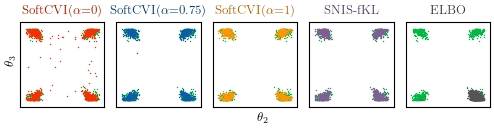

In [5]:
## For SLCP we focus on the posterior marginal showing the four modes
from copy import copy

samples = copy(task_samples["slcp"])
true_samples = samples.pop("True")

fig, axes = plt.subplots(ncols=len(samples))

for ax, (k, v) in zip(axes, samples.items(), strict=False):
    s = 1
    ax.scatter(
        true_samples["theta"][:, 2],
        true_samples["theta"][:, 3],
        s=s,
        label="True",
        color=palette["True"],
        rasterized=True,
        linewidth=0,
        )
    ax.scatter(
        v["theta"][:, 2],
        v["theta"][:, 3],
        label=k,
        s=s,
        color=palette[k],
        rasterized=True,       
        linewidth=0,
        )
    ax.set_box_aspect(1)
    def get_lim(arr):
        iqr = jnp.quantile(arr, 0.75) - jnp.quantile(arr, 0.25)
        return jnp.min(arr) - 0.1*iqr, jnp.max(arr) + 0.1*iqr
    
    ax.set_xlim(*get_lim(true_samples["theta"][:, 2]))
    ax.set_ylim(*get_lim(true_samples["theta"][:, 3]))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

    # Make title a little darker so can read easier
    title_color = matplotlib.colors.ColorConverter.to_rgb(palette[k])
    title_color = tuple(0.7*c for c in title_color)
    ax.set_title(k, color=title_color, fontdict={"fontsize": 9})

fig.supxlabel(r"$\theta_2$",  x= 0.535, y=0.23, fontsize=9)
fig.supylabel(r"$\theta_3$", x=0.035,  y=0.545, fontsize=9)
fig.tight_layout()
fig.set_size_inches(5.15, 2)
fig.savefig(f"plots/plots/slcp_mass_covering_{hyperparam_str}.pdf", dpi=450)
